# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI model learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard version of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 10K from 10x Genomics.

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from pathlib import Path

/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Initialization

Load data and select the top 1000 variable genes with seurat_v3 method

In [4]:
# data_file = "/home/olavdc/github/linearSCVI_experiments/GSE48350_series_matrix.txt"
# f = open(data_file, "r")x
# print(f.read())

Create adata object

In [5]:
# count_csv_file = Path("/home/olavdc/github/linearSCVI_experiments/data/GSE138852_counts.csv")
# covariate_csv_file = Path("/home/olavdc/github/linearSCVI_experiments/data/GSE138852_covariates.csv")

# count_csv = pd.read_csv(count_csv_file, index_col=0)
# covariates_csv = pd.read_csv(covariate_csv_file, index_col=0)

# covariates_csv.columns = covariates_csv.columns.str.replace('oupSample.', '', regex=True)

# adata = anndata.AnnData(X = count_csv, obs = covariates_csv)

Load adata object

In [6]:
AD_genes_df = pd.read_csv("/home/olavdc/github/linearSCVI_experiments/data/AD_genes.csv")

In [7]:
adata = sc.read("/home/olavdc/github/linearSCVI_experiments/data/GSE138852.h5ad")

In [8]:
adata_genes = adata.var.index

In [9]:
# extract non-AD genes
non_AD_genes = []

for gene in adata_genes:
    if gene not in AD_genes_df["Gene Symbol"].values:
        non_AD_genes.append(gene)

# create adata object with only non-AD genes
adata_non_AD = adata[:, adata.var_names.isin(non_AD_genes)]

# pre-process
adata_non_AD.layers["non_AD_counts"] = adata_non_AD.X.copy() # preserve counts
sc.pp.normalize_total(adata_non_AD, target_sum=10e4)
sc.pp.log1p(adata_non_AD)
adata_non_AD.raw = adata_non_AD

# extract HVGs from it
n_genes = 100
pcnt_AD_genes = 0.5
pcnt_non_AD_genes = 1 - pcnt_AD_genes
n_non_AD_genes = n_genes * pcnt_non_AD_genes
sc.pp.highly_variable_genes(
    adata_non_AD, flavor="seurat_v3", layer="non_AD_counts", n_top_genes= n_non_AD_genes, subset=True
)

/tmp/ipykernel_3484/1528929873.py:12: ImplicitModificationWarning: Setting element `.layers['non_AD_counts']` of view, initializing view as actual.
  adata_non_AD.layers["non_AD_counts"] = adata_non_AD.X.copy() # preserve counts


In [10]:
AD_genes = []
n_AD_genes = pcnt_AD_genes * n_genes
gene_count = 0 

for gene in AD_genes_df["Gene Symbol"]:
    if gene in adata_genes:
        if gene_count < n_AD_genes: 
            AD_genes.append(gene)
            gene_count += 1

adata_AD = adata[:, adata.var_names.isin(AD_genes)]

In [11]:
adata_AD

View of AnnData object with n_obs × n_vars = 13214 × 50
    obs: 'batchCond', 'cellType', 'cellType_batchCond', 'subclustID', 'subclustCond'

In [12]:
test_adata = ad.concat([adata_non_AD, adata_AD], axis = 1)

/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/anndata/_core/merge.py:1410: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [13]:
test_adata.obs = adata_non_AD.obs

In [14]:
test_adata

AnnData object with n_obs × n_vars = 13214 × 100
    obs: 'batchCond', 'cellType', 'cellType_batchCond', 'subclustID', 'subclustCond'

In [15]:
test_adata.layers["counts"] = test_adata.X.copy()

In [16]:
scvi.model.LinearSCVI.setup_anndata(test_adata, layer="counts")

/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


## Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LinearSCVI` model. Here we set the latent space to have 10 dimensions.

In [17]:
n_latent = 20 
# initialize LinearSCVI model
model = scvi.model.LinearSCVI(
    test_adata,
    use_batch_norm=False,
    gene_likelihood = "nb",
    n_latent=n_latent)

/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/scvi/model/_linear_scvi.py:94: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(self.adata_manager, n_batch)


In [18]:
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="linearSCVI-tests")

In [19]:
# train for 250 epochs, compute metrics every 10 epochs
model.train(
    max_epochs=40, 
    plan_kwargs={"lr": 7e-3},
    logger = wandb_logger,
    early_stopping = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: olav-declerck (deeplife) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 40/40: 100%|██████████| 40/40 [00:27<00:00,  1.47it/s, v_num=5jn9, train_loss_step=28.2, train_loss_epoch=29.4]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s, v_num=5jn9, train_loss_step=28.2, train_loss_epoch=29.4]


Load Z & W

Inspecting the convergence

In [20]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z
Z_df = pd.DataFrame(Z_hat, adata.obs.index)
Z_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AAACCTGGTAGAAAGG_AD5_AD6,0.321515,0.142858,0.658840,-1.206426,0.680261,-0.960659,-0.390673,2.311900,1.758269,0.767393,-0.811888,0.657881,0.698489,-1.209206,-0.426859,-0.394240,0.399265,-1.208207,-1.110903,0.242916
AAACCTGGTAGCGATG_AD5_AD6,-0.640009,1.021095,1.678606,-1.763749,-0.314835,0.746167,1.350933,1.494691,1.184944,-0.788460,-0.698510,-0.069206,0.363689,-0.160665,-0.202942,0.768416,1.463908,-1.512941,0.850136,0.486384
AAACCTGTCAGTCAGT_AD5_AD6,-0.557239,0.361801,1.468185,-0.477205,0.583294,-0.280306,0.732800,0.657972,2.100291,-0.606413,0.904516,-1.100289,1.131237,-1.465594,-1.798860,0.341143,0.786675,-1.839749,0.283227,0.414118
AAACCTGTCCAAACAC_AD5_AD6,-0.810899,1.568265,1.075779,0.288206,0.546579,-0.299236,-1.708427,1.283132,-0.837557,-0.388653,0.902238,0.202074,0.950457,-0.737298,-1.354209,0.615978,0.756743,-1.941421,1.324398,-0.296730
AAACCTGTCCAGTATG_AD5_AD6,-1.431348,0.038399,0.634558,-1.636136,0.534451,-0.787353,0.115782,1.421401,0.091208,-0.310460,-1.222324,0.050984,0.710776,-0.502552,0.599343,-1.224143,0.560181,-1.688262,-0.773103,0.670701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCGTACAA_AD1_AD2,-1.399021,1.156926,0.766203,1.775924,0.592379,-0.947111,0.231645,0.539431,0.388249,0.112618,0.833100,0.939148,0.205330,-1.121411,-2.754566,-1.251227,1.578698,-0.706970,-0.255478,0.101918
TTTGTCACAAGCCATT_AD1_AD2,-2.935165,-0.071413,0.894118,0.428440,-0.027604,0.149541,-0.107696,0.871309,0.412754,-0.754636,0.051134,-0.569187,1.545767,-0.692298,-1.253140,-0.533138,-0.060728,-0.783332,-0.208908,-0.221042
TTTGTCAGTATAGGTA_AD1_AD2,-1.047667,1.733438,0.866650,-0.763474,1.758018,0.993984,-0.757580,-0.205035,-0.853638,-0.111967,-1.341199,-0.328903,1.609631,-1.451359,0.366758,-1.228635,0.257284,-0.872179,0.725896,1.981327
TTTGTCATCCACTGGG_AD1_AD2,-0.438854,0.409440,-0.048334,0.704297,1.489126,-1.244295,-0.654943,-0.225975,0.147613,0.792124,0.966424,-1.409274,1.322347,-1.183039,0.191584,0.055071,-0.354695,0.019690,-2.835572,-0.924677


In [21]:
W_df = model.get_loadings()
W_df.index = test_adata.var.index
W_df

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,Z_10,Z_11,Z_12,Z_13,Z_14,Z_15,Z_16,Z_17,Z_18,Z_19
SRGAP2B,-0.137914,-0.472174,-0.315263,-0.323855,-0.822209,0.125551,-0.390539,0.305601,0.392569,-0.468120,0.192655,-0.156318,-0.937542,-0.805201,-0.000799,-0.301242,0.230743,1.198334,1.349034,1.502336
RGS16,0.631428,0.355954,0.425672,0.039847,-0.137731,0.402543,0.394382,0.440947,-0.449619,-0.170815,0.170402,0.291404,-0.681573,-0.020695,-0.891964,0.621781,-0.651426,0.069713,-0.034343,0.976260
G0S2,1.434470,-0.417872,0.425034,-0.651181,0.754735,-0.352074,0.475311,-1.032813,-0.165211,-0.358210,0.411497,-0.081002,0.346115,-0.142705,-0.609365,-0.212448,-0.887760,0.796814,-0.396269,-0.074497
MIR3681HG,1.775529,-0.899725,-0.903478,-1.118853,-0.004430,-0.633160,-0.177849,-2.031092,-0.222165,0.232392,0.409648,0.420780,0.381895,0.319147,-0.628759,0.656399,-0.188133,0.670317,-0.578519,-0.656598
ZNF385D,-0.403461,-1.422797,-0.346258,0.214245,0.482871,0.454334,0.938611,-0.846112,-0.322000,0.200403,-1.058729,-0.860978,-0.261596,-0.149623,1.502196,0.819317,0.325391,1.908360,-1.073473,-0.201926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FBXO7,-0.287370,-0.061858,-0.051424,0.538236,-0.359298,-0.276775,0.063168,0.222796,0.346766,0.779004,0.549907,0.095974,0.333578,-0.637102,-0.031628,-0.980008,0.114385,-0.238523,0.326021,-0.339112
PLA2G6,-0.163959,0.039153,0.359847,-0.943087,-0.638643,-0.151704,-0.489279,-0.009220,-0.528618,0.471824,-0.323138,-0.193217,0.722433,-0.240453,-0.012924,0.554748,0.094677,0.486208,-0.158460,-0.335660
ARSA,-0.596131,-0.182044,-0.495419,-0.180389,-0.422070,0.596120,0.116712,0.188650,-0.358245,0.315115,0.053538,0.445945,0.647503,-0.200122,-0.239009,-0.249815,0.214400,-0.147604,0.021438,-0.078947
APP,-0.869090,0.213257,0.901787,0.014702,0.347896,0.012613,-0.021821,0.225628,0.872412,0.179645,0.084725,0.395496,0.085912,-0.147661,0.525842,-0.828294,0.807223,-0.460386,-0.456455,-0.532968


In [22]:
# Z_df = pd.read_csv("Z_df.csv" , index_col=0)
# W_df = pd.read_csv("W_df.csv", index_col=0)

In [23]:
Z_df = Z_df.add_prefix('z')
# W_df = W_df.add_prefix('z')

In [24]:
def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [25]:
_, variance_explained = Z_covariance(Z_df)
idx = np.argsort(variance_explained)[::-1]

In [26]:
variance_explained

array([0.07144055, 0.03037762, 0.06242779, 0.05816748, 0.05521689,
       0.05321549, 0.04304328, 0.04376265, 0.04400372, 0.05275981,
       0.05204808, 0.0512326 , 0.05045365, 0.05008321, 0.04520934,
       0.04586162, 0.04869598, 0.04675335, 0.04779764, 0.04744926])

In [27]:
Z_df_ordered = pd.DataFrame(Z_df.values[:, idx]).add_prefix('z')
Z_df_ordered.index = Z_df.index
W_df_ordered = pd.DataFrame(W_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = W_df.index

In [28]:
text_shift = {
    (0, 'Fst'): (0.2, -0.2),
    (0, 'Pmp22'): (-0.1, -0.3),
    (0, 'Hoxaas3'): (0.0, 0.3),
    (0, 'Acta2'): (0.0, 0.2),
    (0, 'Nnat'): (0.0, 0.5),
    (0, 'Ifitm1'): (0.0, 0.2),
    
    (1, 'Srgn'): (0., -0.2),
    (1, 'Amn'): (-0.7, 0.),
    
    (2, 'Crabp2'): (0.0, 0.4),
    (2, 'Tdgf1'): (0.0, 0.4),
    (2, 'Cer1'): (-0.6, 0.0),
    (2, 'T'): (-1.3, 0.0),
    
    (3, 'Cdx1'): (0.0, 0.4),
    (3, 'Cdx2'): (-1.0, 0.7),
    (3, 'Cited1'): (-1.6, -0.0),
    (3, 'Phlda2'): (-0.7, 0.0),
    (3, 'T'): (0.0, 0.2),
    (3, 'Ifitm1'): (-0.2, 0.0),
#     (3, 'Rspo2'): (-0.3, 0.0),
#     (3, 'Htr2c'): (0.6, 0.1),
#     (3, 'Col1a1'): (0.0, 0.2),
    
#     (4, 'Ttn'): (0.0, -0.4),
#     (4, 'Sntb1'): (0.0, -0.3),
#     (4, 'Colec12'): (-1.1, 0.1),
#     (4, 'Adam12'): (0.1, 0.4),
#     (4, 'Spon1'): (0.0, 0.2),
#     (4, 'Gm3764'): (-0.2, 0.3),
#     (4, 'C130071C03Rik'): (1.5, -0.35),
    
}

In [29]:
W_df_ordered["gene_name"] = W_df_ordered.index

In [30]:
W_df_ordered

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w11,w12,w13,w14,w15,w16,w17,w18,w19,gene_name
SRGAP2B,-0.137914,-0.315263,-0.323855,-0.822209,0.125551,-0.468120,0.192655,-0.156318,-0.937542,-0.805201,...,1.349034,1.502336,1.198334,-0.301242,-0.000799,0.392569,0.305601,-0.390539,-0.472174,SRGAP2B
RGS16,0.631428,0.425672,0.039847,-0.137731,0.402543,-0.170815,0.170402,0.291404,-0.681573,-0.020695,...,-0.034343,0.976260,0.069713,0.621781,-0.891964,-0.449619,0.440947,0.394382,0.355954,RGS16
G0S2,1.434470,0.425034,-0.651181,0.754735,-0.352074,-0.358210,0.411497,-0.081002,0.346115,-0.142705,...,-0.396269,-0.074497,0.796814,-0.212448,-0.609365,-0.165211,-1.032813,0.475311,-0.417872,G0S2
MIR3681HG,1.775529,-0.903478,-1.118853,-0.004430,-0.633160,0.232392,0.409648,0.420780,0.381895,0.319147,...,-0.578519,-0.656598,0.670317,0.656399,-0.628759,-0.222165,-2.031092,-0.177849,-0.899725,MIR3681HG
ZNF385D,-0.403461,-0.346258,0.214245,0.482871,0.454334,0.200403,-1.058729,-0.860978,-0.261596,-0.149623,...,-1.073473,-0.201926,1.908360,0.819317,1.502196,-0.322000,-0.846112,0.938611,-1.422797,ZNF385D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FBXO7,-0.287370,-0.051424,0.538236,-0.359298,-0.276775,0.779004,0.549907,0.095974,0.333578,-0.637102,...,0.326021,-0.339112,-0.238523,-0.980008,-0.031628,0.346766,0.222796,0.063168,-0.061858,FBXO7
PLA2G6,-0.163959,0.359847,-0.943087,-0.638643,-0.151704,0.471824,-0.323138,-0.193217,0.722433,-0.240453,...,-0.158460,-0.335660,0.486208,0.554748,-0.012924,-0.528618,-0.009220,-0.489279,0.039153,PLA2G6
ARSA,-0.596131,-0.495419,-0.180389,-0.422070,0.596120,0.315115,0.053538,0.445945,0.647503,-0.200122,...,0.021438,-0.078947,-0.147604,-0.249815,-0.239009,-0.358245,0.188650,0.116712,-0.182044,ARSA
APP,-0.869090,0.901787,0.014702,0.347896,0.012613,0.179645,0.084725,0.395496,0.085912,-0.147661,...,-0.456455,-0.532968,-0.460386,-0.828294,0.525842,0.872412,0.225628,-0.021821,0.213257,APP


['IDI1' 'MIR3681HG' 'CHST11' 'RP4-668E10.4' 'C10orf11' 'BCYRN1' 'GPR183'
 'RP5-1031D4.2']
['SLC5A11' 'LPAR6' 'GPR183' 'RP11-649A16.1' 'CEMIP' 'SRGN' 'MIR4300HG'
 'RP5-1031D4.2']
['CDH18' 'RP4-668E10.4' 'C10orf11' 'FAM155A' 'PINK1' 'PAMR1' 'RNF219-AS1'
 'HTRA2']
['CTA-29F11.1' 'MT1G' 'MIR4300HG' 'RP11-123O10.4' 'RP11-191L9.4' 'ZNF385D'
 'LPAR6' 'WBSCR17']
['GALNTL6' 'PAMR1' 'TPD52L1' 'HS6ST3' 'MT1G' 'RP4-668E10.4' 'GFAP'
 'C10orf11']
['INPP4B' 'CTD-3179P9.1' 'CDH18' 'CEMIP' 'CHST11' 'RP11-649A16.1'
 'NDUFA4L2' 'SRGAP2B']
['RP11-624C23.1' 'XKR4' 'WBSCR17' 'SRGAP2B' 'ZNF385D' 'CTA-29F11.1'
 'GPR183' 'IDI1']
['LINC01088' 'IDI1' 'ZNF385D' 'WBSCR17' 'TPD52L1' 'ZNF804B'
 'RP11-317N12.1' 'MT-ND1']


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


['MIR3681HG' 'HS6ST3' 'CA10' 'RNF219-AS1' 'LINC01088' 'RP4-668E10.4'
 'MT1G' 'CDH18']
['CDH18' 'IDI1' 'ZNF385D' 'NDUFA4L2' 'LINC01088' 'RP4-668E10.4' 'GALNTL6'
 'SLC5A11']


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

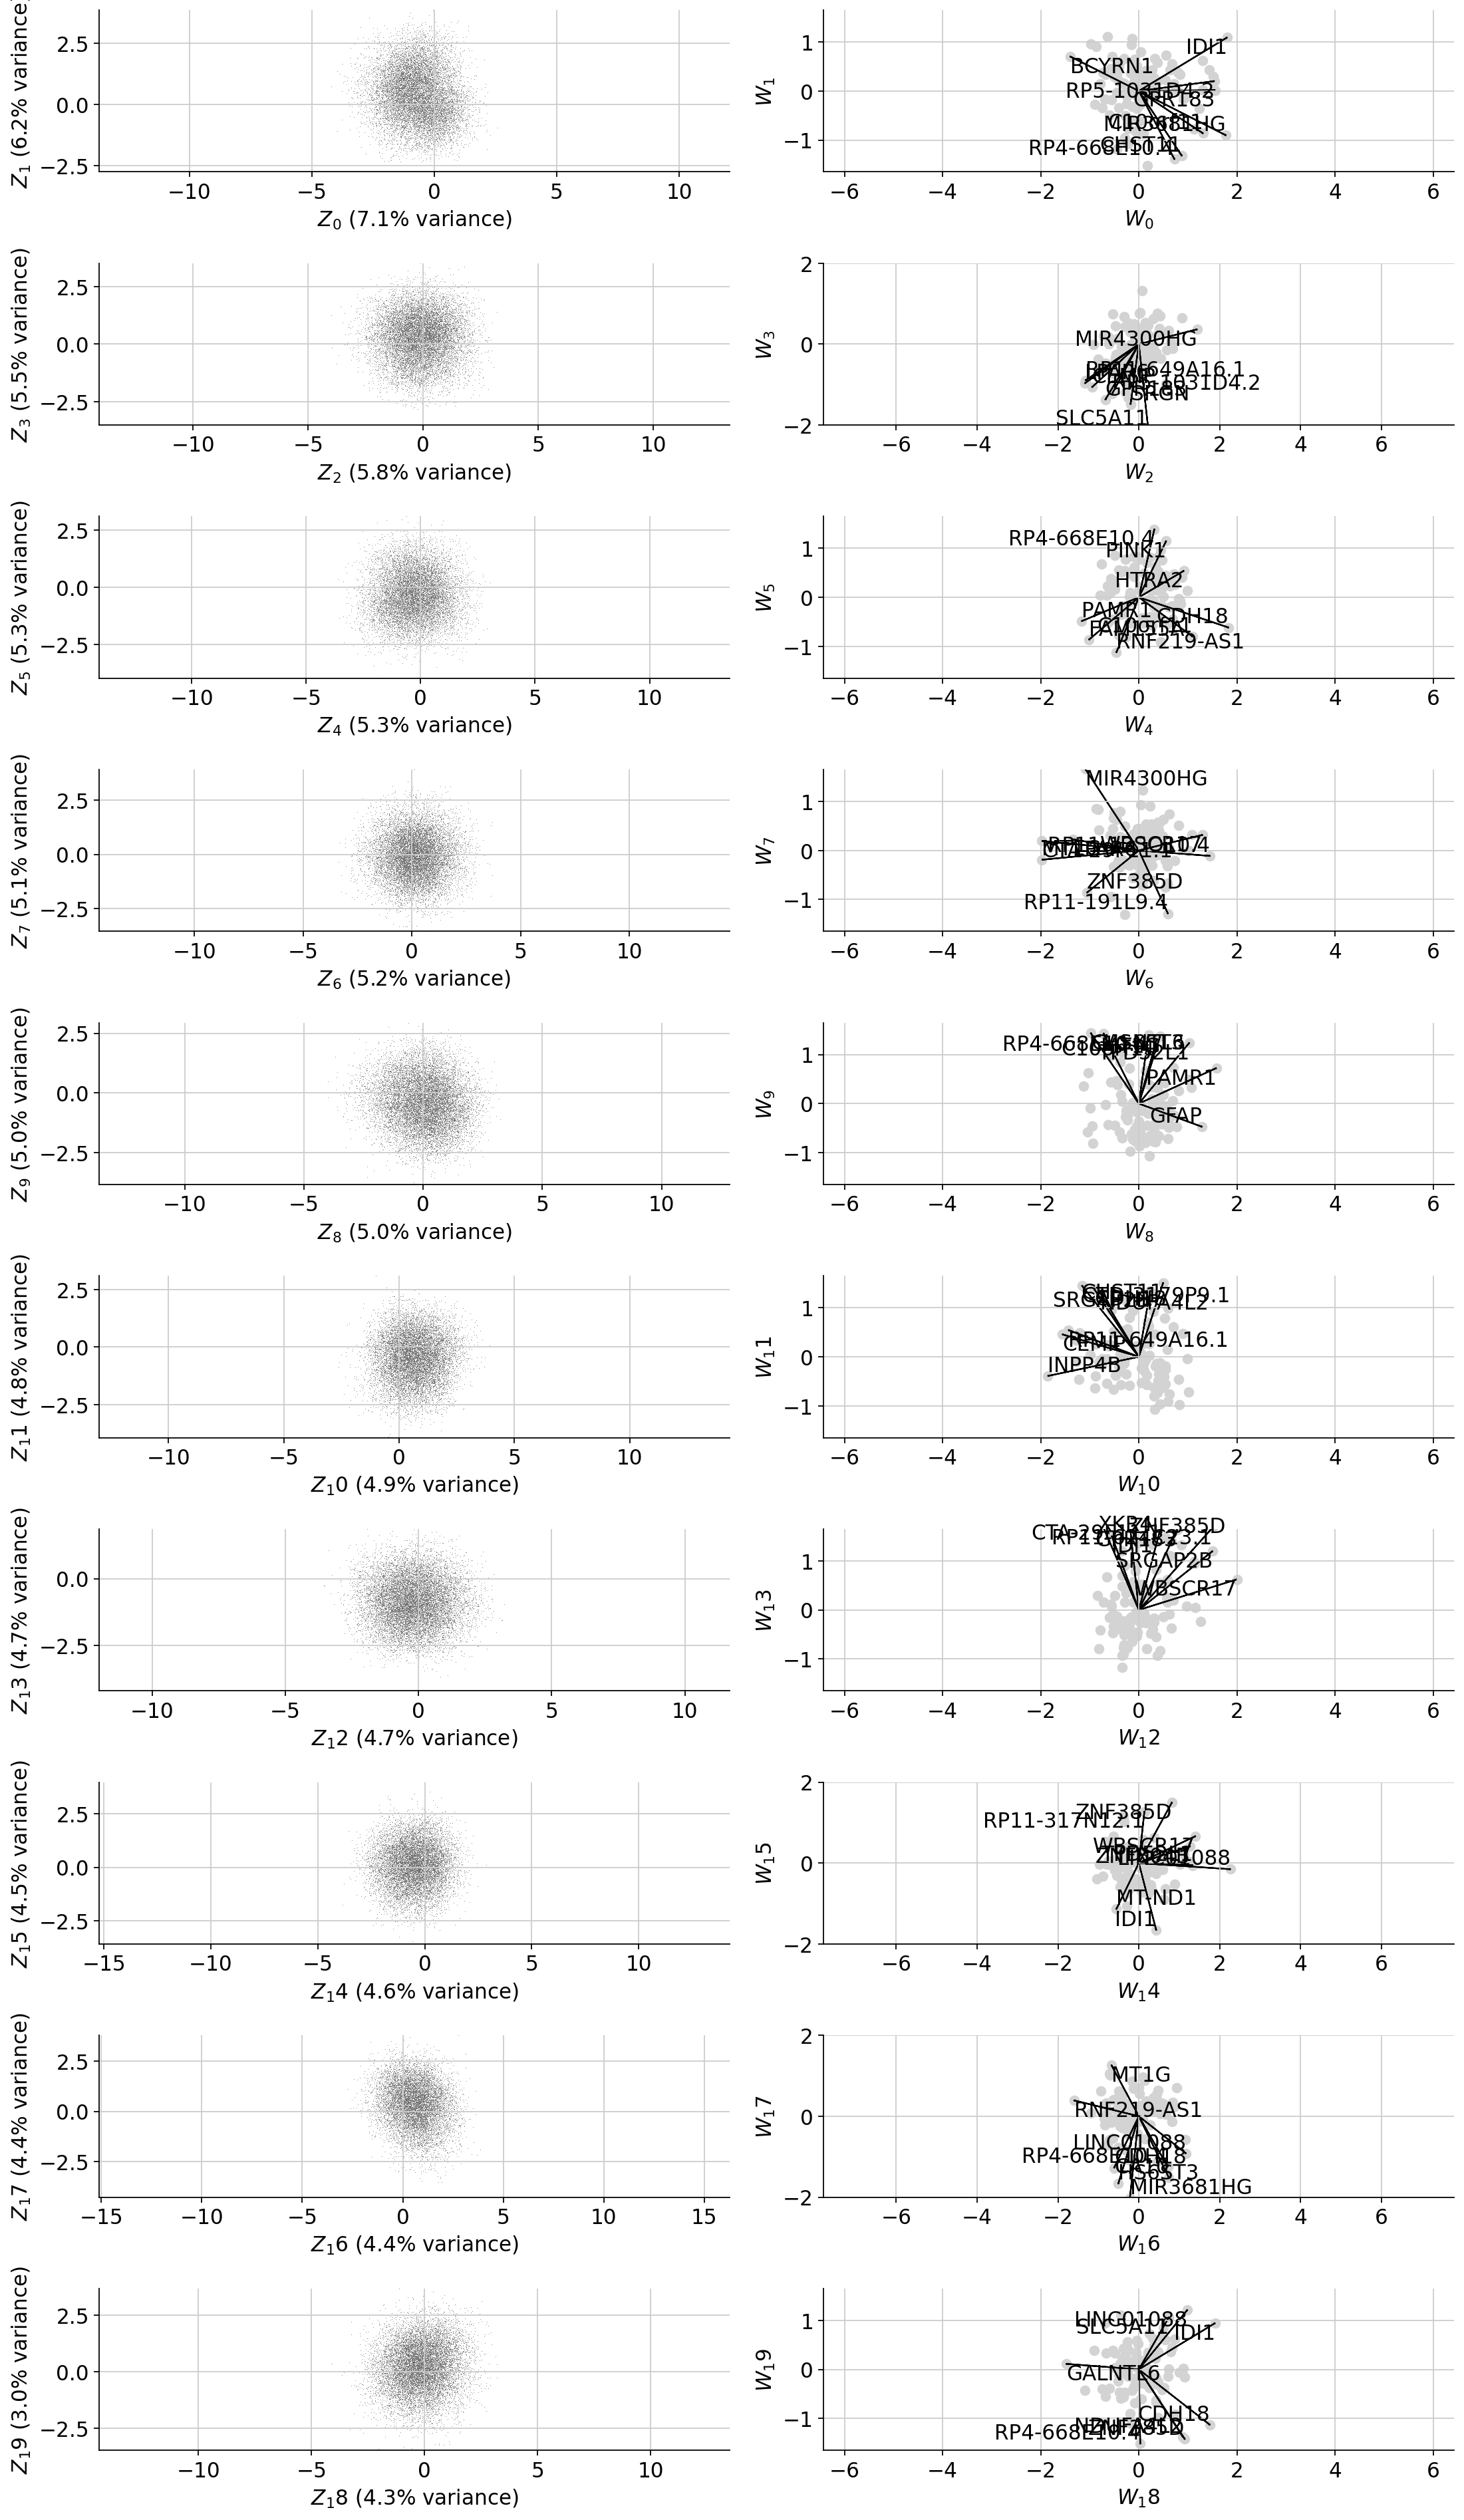

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define figure size
plt.figure(figsize=(14, 24))

# Iterate for each plot
for i in range(10):
    
    # -- Z plot --
    plt.subplot(10, 2, 2 * i + 1)
    
    plt.hist2d(
        Z_df_ordered[f'z{2 * i}'], Z_df_ordered[f'z{2 * i + 1}'],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )
    plt.axis('equal')
    plt.xlabel(f'$Z_{2 * i}$ ({variance_explained[idx][2 * i]:.1%} variance)')
    plt.ylabel(f'$Z_{2 * i + 1}$ ({variance_explained[idx][2 * i + 1]:.1%} variance)')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # -- W plot --
    plt.subplot(10, 2, 2 * i + 2)
    
    w_columns = [f'w{2 * i}', f'w{2 * i + 1}']
    
    plt.scatter(
        W_df_ordered[w_columns[0]], W_df_ordered[w_columns[1]],
        c='lightgrey',
        rasterized=True
    )
    plt.axis('equal')
    plt.xlabel(f'$W_{2 * i}$')
    plt.ylabel(f'$W_{2 * i + 1}$')
    
    tmp_ = W_df_ordered.copy()
    tmp_['lnth'] = np.linalg.norm(tmp_[w_columns], axis=1)
    
    ggg = (
        tmp_
        .sort_values('lnth', ascending=False)
        .head(8)[['gene_name', 'lnth', *w_columns]]
    )
    print(ggg['gene_name'].values)
    
    texts = []
    arrows = []
    for g, r in ggg.iterrows():
        x_, y_ = r[w_columns[0]], r[w_columns[1]]
        
        ha = 'right' if x_ > 0 else 'left'
        va = 'top' if y_ > 0 else 'bottom'
        
        arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='black'))
        
        xs, ys = 0, 0
        if (i, r.gene_name) in text_shift:
            xs, ys = text_shift[(i, r.gene_name)]
        
        texts.append(plt.text(x_ + xs, y_ + ys, r.gene_name, ha=ha, va=va))

    plt.xlim(left=-2, right=2)
    plt.ylim(bottom=-2, top=2)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout to fit plots
plt.tight_layout()

# Save figure as a PDF with high resolution
# plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=400)


In [32]:
metadata = test_adata.obs.loc[Z_df_ordered.index]

In [33]:
metadata

,batchCond,cellType,cellType_batchCond,subclustID,subclustCond,_scvi_batch,_scvi_labels
AAACCTGGTAGAAAGG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0
AAACCTGGTAGCGATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0
AAACCTGTCAGTCAGT_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0
AAACCTGTCCAAACAC_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0
AAACCTGTCCAGTATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0
...,...,...,...,...,...,...,...
TTTGGTTTCCGTACAA_AD1_AD2,AD,oligo,oligo_AD,o3,AD,0,0
TTTGTCACAAGCCATT_AD1_AD2,AD,doublet,doublet_AD,d2,AD,0,0
TTTGTCAGTATAGGTA_AD1_AD2,AD,doublet,doublet_AD,d4,undetermined,0,0
TTTGTCATCCACTGGG_AD1_AD2,AD,oligo,oligo_AD,o1,AD,0,0


In [34]:
metadata = metadata.join(Z_df_ordered)

In [35]:
metadata.head().T

,AAACCTGGTAGAAAGG_AD5_AD6,AAACCTGGTAGCGATG_AD5_AD6,AAACCTGTCAGTCAGT_AD5_AD6,AAACCTGTCCAAACAC_AD5_AD6,AAACCTGTCCAGTATG_AD5_AD6
batchCond,AD,AD,AD,AD,AD
cellType,oligo,oligo,oligo,oligo,oligo
cellType_batchCond,oligo_AD,oligo_AD,oligo_AD,oligo_AD,oligo_AD
subclustID,o3,o3,o3,o3,o3
subclustCond,AD,AD,AD,AD,AD
_scvi_batch,0,0,0,0,0
_scvi_labels,0,0,0,0,0
z0,0.321515,-0.640009,-0.557239,-0.810899,-1.431348
z1,0.65884,1.678606,1.468185,1.075779,0.634558
z2,-1.206426,-1.763749,-0.477205,0.288206,-1.636136


In [36]:
Z_df_ordered

,z0,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19
AAACCTGGTAGAAAGG_AD5_AD6,0.321515,0.658840,-1.206426,0.680261,-0.960659,0.767393,-0.811888,0.657881,0.698489,-1.209206,0.399265,-1.110903,0.242916,-1.208207,-0.394240,-0.426859,1.758269,2.311900,-0.390673,0.142858
AAACCTGGTAGCGATG_AD5_AD6,-0.640009,1.678606,-1.763749,-0.314835,0.746167,-0.788460,-0.698510,-0.069206,0.363689,-0.160665,1.463908,0.850136,0.486384,-1.512941,0.768416,-0.202942,1.184944,1.494691,1.350933,1.021095
AAACCTGTCAGTCAGT_AD5_AD6,-0.557239,1.468185,-0.477205,0.583294,-0.280306,-0.606413,0.904516,-1.100289,1.131237,-1.465594,0.786675,0.283227,0.414118,-1.839749,0.341143,-1.798860,2.100291,0.657972,0.732800,0.361801
AAACCTGTCCAAACAC_AD5_AD6,-0.810899,1.075779,0.288206,0.546579,-0.299236,-0.388653,0.902238,0.202074,0.950457,-0.737298,0.756743,1.324398,-0.296730,-1.941421,0.615978,-1.354209,-0.837557,1.283132,-1.708427,1.568265
AAACCTGTCCAGTATG_AD5_AD6,-1.431348,0.634558,-1.636136,0.534451,-0.787353,-0.310460,-1.222324,0.050984,0.710776,-0.502552,0.560181,-0.773103,0.670701,-1.688262,-1.224143,0.599343,0.091208,1.421401,0.115782,0.038399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCGTACAA_AD1_AD2,-1.399021,0.766203,1.775924,0.592379,-0.947111,0.112618,0.833100,0.939148,0.205330,-1.121411,1.578698,-0.255478,0.101918,-0.706970,-1.251227,-2.754566,0.388249,0.539431,0.231645,1.156926
TTTGTCACAAGCCATT_AD1_AD2,-2.935165,0.894118,0.428440,-0.027604,0.149541,-0.754636,0.051134,-0.569187,1.545767,-0.692298,-0.060728,-0.208908,-0.221042,-0.783332,-0.533138,-1.253140,0.412754,0.871309,-0.107696,-0.071413
TTTGTCAGTATAGGTA_AD1_AD2,-1.047667,0.866650,-0.763474,1.758018,0.993984,-0.111967,-1.341199,-0.328903,1.609631,-1.451359,0.257284,0.725896,1.981327,-0.872179,-1.228635,0.366758,-0.853638,-0.205035,-0.757580,1.733438
TTTGTCATCCACTGGG_AD1_AD2,-0.438854,-0.048334,0.704297,1.489126,-1.244295,0.792124,0.966424,-1.409274,1.322347,-1.183039,-0.354695,-2.835572,-0.924677,0.019690,0.055071,0.191584,0.147613,-0.225975,-0.654943,0.409440


In [37]:
for batch_condition in np.unique(metadata['batchCond']):
    z_corrs = Z_df_ordered.corrwith((metadata['batchCond'] == batch_condition))
    top_factors = z_corrs.map(np.abs).sort_values(ascending=False).head()
    print([f'{z.rjust(3)}: {z_corrs[z]:+.2f}' for z in top_factors.index], batch_condition)

[' z9: -0.31', ' z0: -0.29', 'z15: -0.26', ' z1: +0.20', 'z10: -0.19'] AD
[' z9: +0.31', ' z0: +0.29', 'z15: +0.26', ' z1: -0.20', 'z10: +0.19'] ct


In [38]:
def make_kde(x1, x2):
    dx1 = (x1.max() - x1.min()) / 10
    dx2 = (x2.max() - x2.min()) / 10

    x1min = x1.min() - dx1
    x2min = x2.min() - dx2
    x1max = x1.max() + dx1
    x2max = x2.max() + dx2

    xx1, xx2 = np.mgrid[x1min:x1max:100j, x2min:x2max:100j]

    positions = np.vstack([xx1.ravel(), xx2.ravel()])
    values = np.vstack([x1, x2])

    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx1.shape)
    
    return xx1, xx2, f

In [39]:
from matplotlib import cm
from scipy import stats


In [40]:
vardata = W_df_ordered

In [41]:
metadata

,batchCond,cellType,cellType_batchCond,subclustID,subclustCond,_scvi_batch,_scvi_labels,z0,z1,z2,...,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19
AAACCTGGTAGAAAGG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,0.321515,0.658840,-1.206426,...,0.399265,-1.110903,0.242916,-1.208207,-0.394240,-0.426859,1.758269,2.311900,-0.390673,0.142858
AAACCTGGTAGCGATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,-0.640009,1.678606,-1.763749,...,1.463908,0.850136,0.486384,-1.512941,0.768416,-0.202942,1.184944,1.494691,1.350933,1.021095
AAACCTGTCAGTCAGT_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,-0.557239,1.468185,-0.477205,...,0.786675,0.283227,0.414118,-1.839749,0.341143,-1.798860,2.100291,0.657972,0.732800,0.361801
AAACCTGTCCAAACAC_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,-0.810899,1.075779,0.288206,...,0.756743,1.324398,-0.296730,-1.941421,0.615978,-1.354209,-0.837557,1.283132,-1.708427,1.568265
AAACCTGTCCAGTATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,-1.431348,0.634558,-1.636136,...,0.560181,-0.773103,0.670701,-1.688262,-1.224143,0.599343,0.091208,1.421401,0.115782,0.038399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCGTACAA_AD1_AD2,AD,oligo,oligo_AD,o3,AD,0,0,-1.399021,0.766203,1.775924,...,1.578698,-0.255478,0.101918,-0.706970,-1.251227,-2.754566,0.388249,0.539431,0.231645,1.156926
TTTGTCACAAGCCATT_AD1_AD2,AD,doublet,doublet_AD,d2,AD,0,0,-2.935165,0.894118,0.428440,...,-0.060728,-0.208908,-0.221042,-0.783332,-0.533138,-1.253140,0.412754,0.871309,-0.107696,-0.071413
TTTGTCAGTATAGGTA_AD1_AD2,AD,doublet,doublet_AD,d4,undetermined,0,0,-1.047667,0.866650,-0.763474,...,0.257284,0.725896,1.981327,-0.872179,-1.228635,0.366758,-0.853638,-0.205035,-0.757580,1.733438
TTTGTCATCCACTGGG_AD1_AD2,AD,oligo,oligo_AD,o1,AD,0,0,-0.438854,-0.048334,0.704297,...,-0.354695,-2.835572,-0.924677,0.019690,0.055071,0.191584,0.147613,-0.225975,-0.654943,0.409440


In [42]:
vardata

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w11,w12,w13,w14,w15,w16,w17,w18,w19,gene_name
SRGAP2B,-0.137914,-0.315263,-0.323855,-0.822209,0.125551,-0.468120,0.192655,-0.156318,-0.937542,-0.805201,...,1.349034,1.502336,1.198334,-0.301242,-0.000799,0.392569,0.305601,-0.390539,-0.472174,SRGAP2B
RGS16,0.631428,0.425672,0.039847,-0.137731,0.402543,-0.170815,0.170402,0.291404,-0.681573,-0.020695,...,-0.034343,0.976260,0.069713,0.621781,-0.891964,-0.449619,0.440947,0.394382,0.355954,RGS16
G0S2,1.434470,0.425034,-0.651181,0.754735,-0.352074,-0.358210,0.411497,-0.081002,0.346115,-0.142705,...,-0.396269,-0.074497,0.796814,-0.212448,-0.609365,-0.165211,-1.032813,0.475311,-0.417872,G0S2
MIR3681HG,1.775529,-0.903478,-1.118853,-0.004430,-0.633160,0.232392,0.409648,0.420780,0.381895,0.319147,...,-0.578519,-0.656598,0.670317,0.656399,-0.628759,-0.222165,-2.031092,-0.177849,-0.899725,MIR3681HG
ZNF385D,-0.403461,-0.346258,0.214245,0.482871,0.454334,0.200403,-1.058729,-0.860978,-0.261596,-0.149623,...,-1.073473,-0.201926,1.908360,0.819317,1.502196,-0.322000,-0.846112,0.938611,-1.422797,ZNF385D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FBXO7,-0.287370,-0.051424,0.538236,-0.359298,-0.276775,0.779004,0.549907,0.095974,0.333578,-0.637102,...,0.326021,-0.339112,-0.238523,-0.980008,-0.031628,0.346766,0.222796,0.063168,-0.061858,FBXO7
PLA2G6,-0.163959,0.359847,-0.943087,-0.638643,-0.151704,0.471824,-0.323138,-0.193217,0.722433,-0.240453,...,-0.158460,-0.335660,0.486208,0.554748,-0.012924,-0.528618,-0.009220,-0.489279,0.039153,PLA2G6
ARSA,-0.596131,-0.495419,-0.180389,-0.422070,0.596120,0.315115,0.053538,0.445945,0.647503,-0.200122,...,0.021438,-0.078947,-0.147604,-0.249815,-0.239009,-0.358245,0.188650,0.116712,-0.182044,ARSA
APP,-0.869090,0.901787,0.014702,0.347896,0.012613,0.179645,0.084725,0.395496,0.085912,-0.147661,...,-0.456455,-0.532968,-0.460386,-0.828294,0.525842,0.872412,0.225628,-0.021821,0.213257,APP


In [43]:
vardata["gene_name"] = vardata.index

In [44]:
# latent_dims = []
# weight_dims = []
# for dim in range(n_latent):
#     latent_dims.append(f'z{dim}')
#     weight_dims.append(f'w{dim}')

In [45]:
top_factors_list = []
for top_factor in top_factors.keys():
    top_factors_list.append(top_factor)

In [46]:
from itertools import combinations

top_factor_pairs = list(combinations(top_factors_list,2))

In [50]:
metadata.columns

Index(['batchCond', 'cellType', 'cellType_batchCond', 'subclustID',
       'subclustCond', '_scvi_batch', '_scvi_labels', 'z0', 'z1', 'z2', 'z3',
       'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11', 'z12', 'z13', 'z14',
       'z15', 'z16', 'z17', 'z18', 'z19'],
      dtype='object')

AAACCTGGTAGAAAGG_AD5_AD6   -1.209206
AAACCTGGTAGCGATG_AD5_AD6   -0.160665
AAACCTGTCAGTCAGT_AD5_AD6   -1.465594
AAACCTGTCCAAACAC_AD5_AD6   -0.737298
AAACCTGTCCAGTATG_AD5_AD6   -0.502552
                              ...   
TTTGGTTTCCGTACAA_AD1_AD2   -1.121411
TTTGTCACAAGCCATT_AD1_AD2   -0.692298
TTTGTCAGTATAGGTA_AD1_AD2   -1.451359
TTTGTCATCCACTGGG_AD1_AD2   -1.183039
TTTGTCATCCGGGTGT_AD1_AD2   -0.588382
Name: z9, Length: 6673, dtype: float32
AAACCTGGTAGAAAGG_AD5_AD6    0.321515
AAACCTGGTAGCGATG_AD5_AD6   -0.640009
AAACCTGTCAGTCAGT_AD5_AD6   -0.557239
AAACCTGTCCAAACAC_AD5_AD6   -0.810899
AAACCTGTCCAGTATG_AD5_AD6   -1.431348
                              ...   
TTTGGTTTCCGTACAA_AD1_AD2   -1.399021
TTTGTCACAAGCCATT_AD1_AD2   -2.935165
TTTGTCAGTATAGGTA_AD1_AD2   -1.047667
TTTGTCATCCACTGGG_AD1_AD2   -0.438854
TTTGTCATCCGGGTGT_AD1_AD2   -0.938142
Name: z0, Length: 6673, dtype: float32
AAACCTGAGTCACGCC_Ct5_Ct6    1.261766
AAACCTGCAGCTGCTG_Ct5_Ct6   -0.944598
AAACCTGCATGGATGG_Ct5_Ct6   -0.3912

KeyboardInterrupt: 

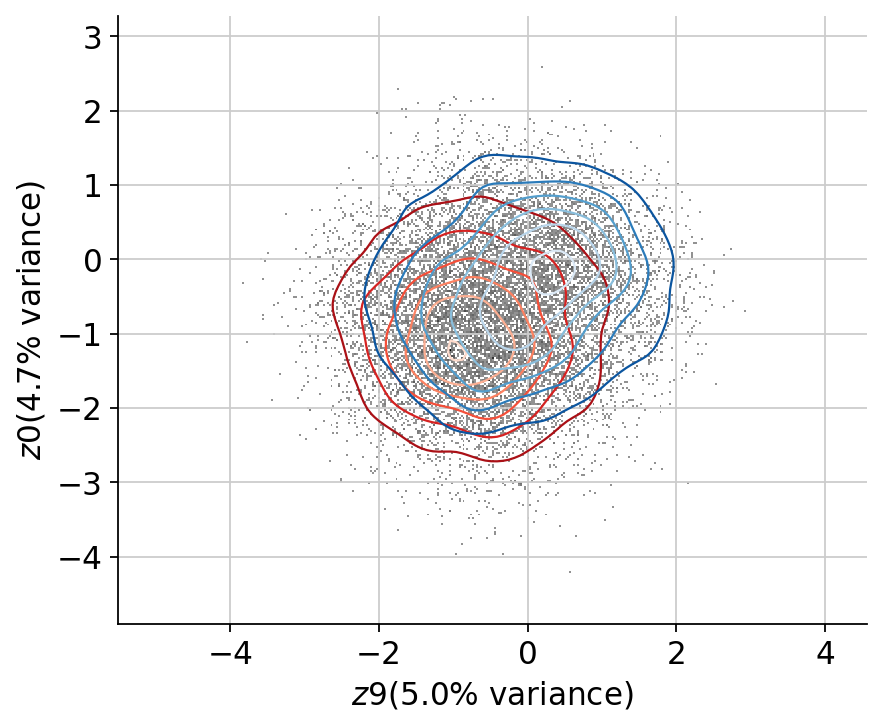

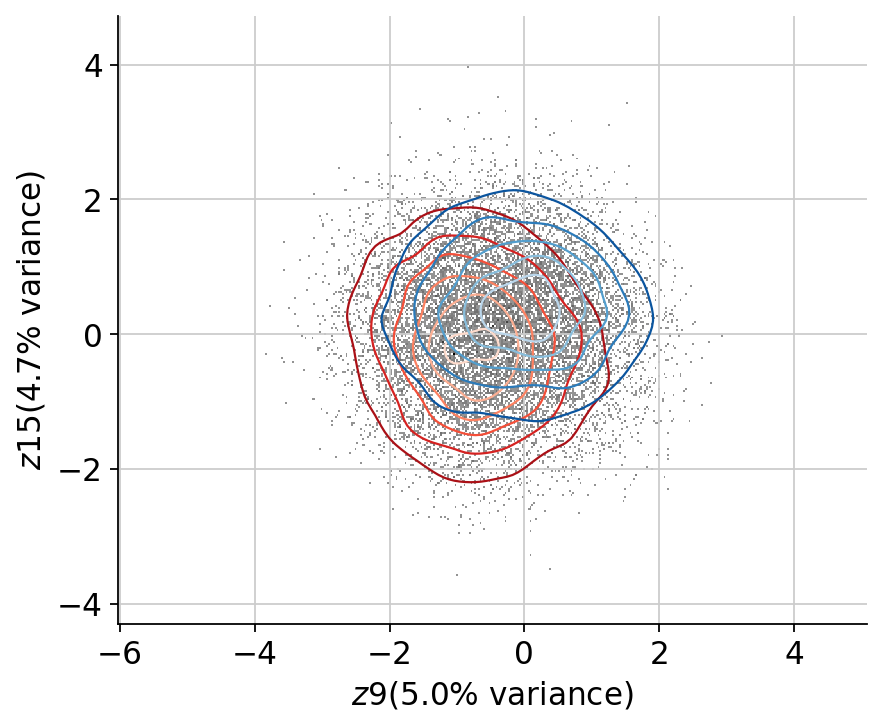

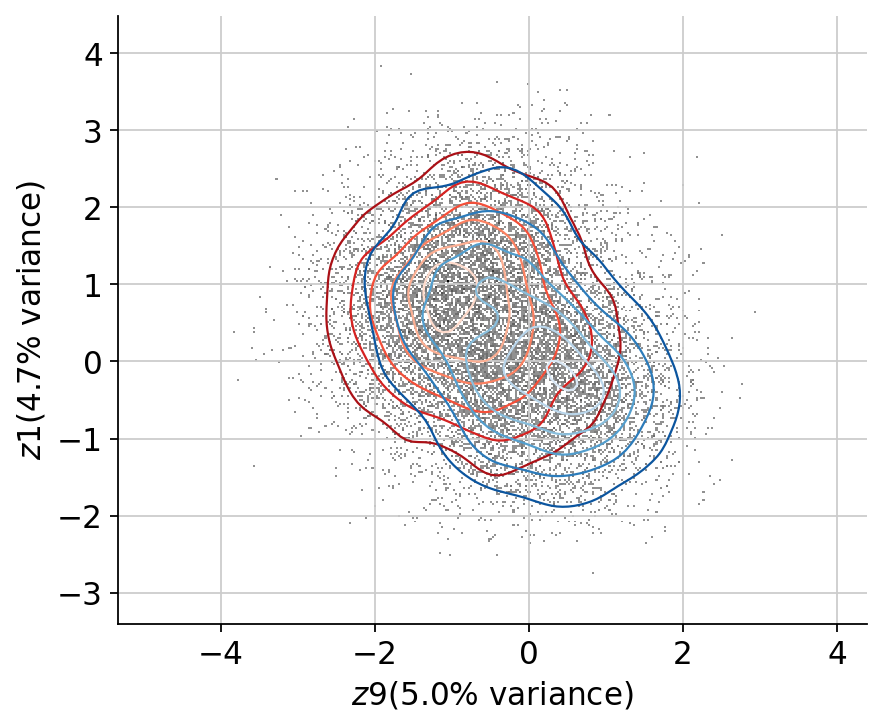

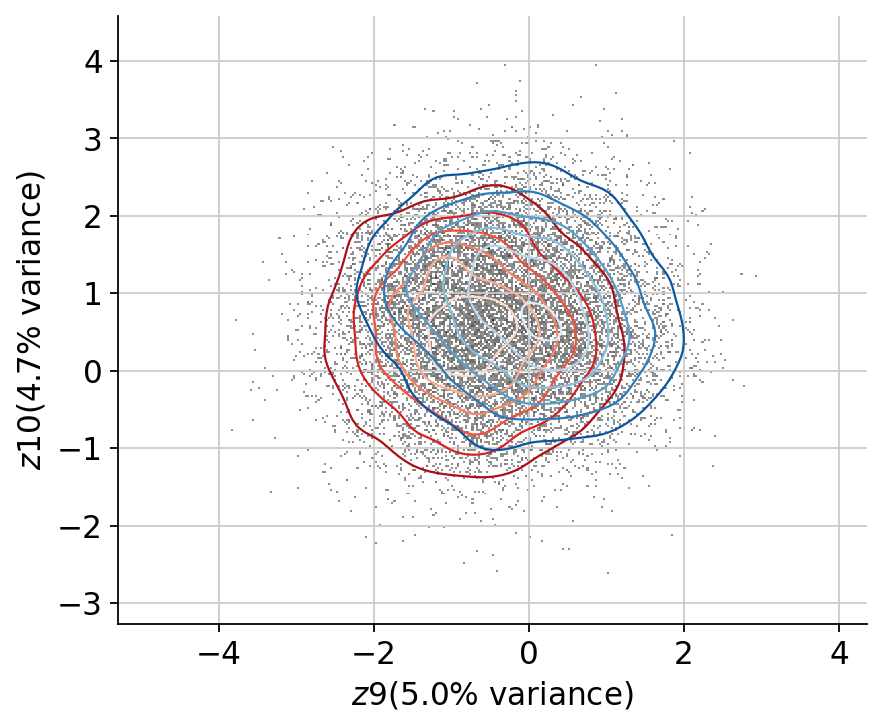

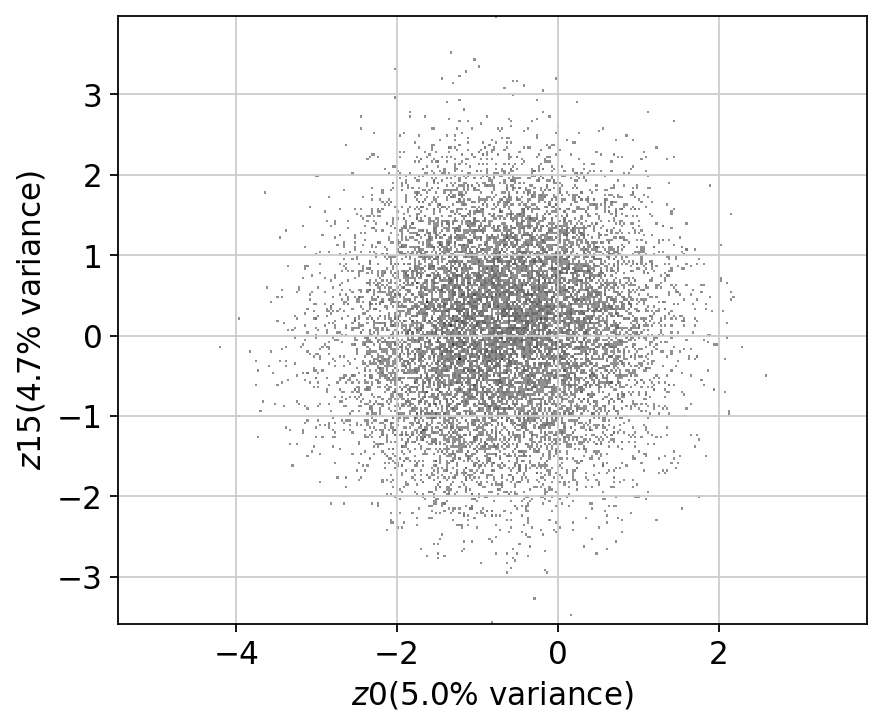

In [48]:
for top_factor_1, top_factor_2 in top_factor_pairs:

    plt.figure(figsize=(6, 5)) 

    plt.hist2d(
        Z_df_ordered[top_factor_1], Z_df_ordered[top_factor_2],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )

    plt.axis('equal')
    plt.xlabel(f'${top_factor_1}$' + f'({variance_explained[idx][9]:.1%} variance)')
    plt.ylabel(f'${top_factor_2}$' + f'({variance_explained[idx][12]:.1%} variance)')

    ax = plt.gca()

    color_maps = [cm.Reds_r, cm.Blues_r]
    conditions = ['AD', 'ct']
    for color, ctype in zip(color_maps, conditions):
        X = metadata.query('batchCond == @ctype')[[top_factor_1, top_factor_2]]
        print(X)
        xx1, xx2, f = make_kde(X[top_factor_1], X[top_factor_2])
        cset = ax.contour(
            xx1,
            xx2,
            f,
            levels=6,
            cmap=color,
            linewidths=1.
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# plt.subplot(1, 2, 2)

# plt.scatter(
#     W_df_ordered[weight_dim_1], W_df_ordered['w17'],
#     c='lightgrey',
#     rasterized=True
# )

# arrows = []
# genes = ['Hbb-bs', 'Hbb-bt', 'Hba-a2']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='r'))
    
# plt.text(0, 2, '\n'.join(genes), color='r')

# arrows = []
# genes = ['Pou5f1', 'Tdgf1', 'Snrpn']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='g'))

# plt.text(1, -1.5, '\n'.join(genes), color='g')

# arrows = []
# genes = ['Ctsh', 'Amn', 'Apoa4']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='b'))

# plt.text(-2.6, -0.5, '\n'.join(genes), color='b')


# plt.xlim(left=-3, right=3)
# plt.ylim(bottom=-3, top=3)

# plt.xlabel(f'${weight_dim_1}$')
# plt.ylabel(f'${weight_dim_2}$')

# ax = plt.gca()

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.savefig('figures/linear_pij_results_celltypes.pdf', bbox_inches='tight', dpi=400)

In [ ]:
AD_genes

['APP',
 'APOE',
 'PSEN1',
 'MAPT',
 'SORL1',
 'BACE1',
 'ABCA7',
 'SNCA',
 'PRNP',
 'A2M',
 'GRN',
 'VCP',
 'CSF1R',
 'MT-ND1',
 'SQSTM1',
 'TOMM40',
 'BDNF-AS',
 'FUS',
 'BLMH',
 'CHMP2B',
 'GFAP',
 'UCHL1',
 'ITM2B',
 'LRRK2',
 'BCYRN1',
 'ADAM10',
 'NPC1',
 'TUBA4A',
 'PLA2G6',
 'PINK1',
 'PARK7',
 'LRP1',
 'TBK1',
 'CHCHD10',
 'ARSA',
 'SIGMAR1',
 'CLU',
 'NOTCH3',
 'ATP7B',
 'GSK3B',
 'VPS35',
 'TYROBP',
 'POLG',
 'CDK5',
 'PSAP',
 'HTRA2',
 'SLC2A1',
 'UBQLN2',
 'PLD3',
 'FBXO7']

In [ ]:
vardata.sort_values('w9', ascending=False)[['w9', 'gene_name']].tail(10)

,w9,gene_name
SORL1,-0.857901,SORL1
BNC2,-0.882864,BNC2
RP11-556E13.1,-0.926633,RP11-556E13.1
A2M,-0.927570,A2M
TYROBP,-0.935233,TYROBP
RP11-624C23.1,-0.970819,RP11-624C23.1
SRGN,-1.091401,SRGN
RP11-30J20.1,-1.105686,RP11-30J20.1
LPAR6,-1.175371,LPAR6
SRGAP2B,-1.372580,SRGAP2B


In [ ]:
"LPAR6" in AD_genes

False

In [ ]:
vardata.sort_values('w5', ascending=False)[['w5', 'gene_name']].tail(10)

,w5,gene_name
HS6ST3,1.905909,HS6ST3
CA10,1.562955,CA10
WBSCR17,1.311465,WBSCR17
RP11-649A16.1,1.204153,RP11-649A16.1
XKR4,1.190359,XKR4
CDH18,1.073742,CDH18
RP11-413B19.2,1.066315,RP11-413B19.2
MIR3681HG,1.052157,MIR3681HG
SLC14A1,1.024125,SLC14A1
NDUFA4L2,0.937425,NDUFA4L2


In [ ]:
vardata.sort_values('w18', ascending=False)[['w18', 'gene_name']].tail(10)

,w18,gene_name
C10orf11,-0.581979,C10orf11
GFAP,-0.602736,GFAP
FAM155A,-0.616582,FAM155A
LRP1,-0.618117,LRP1
PAMR1,-0.661576,PAMR1
FUS,-0.665548,FUS
RP4-668E10.4,-0.745281,RP4-668E10.4
IQCJ-SCHIP1,-0.888732,IQCJ-SCHIP1
HS6ST3,-1.065329,HS6ST3
CHST11,-1.190954,CHST11
